#Processing of the MQ sensors' logs

In this **project**, we'll build a neural network and use it to predict food quality.

In [1]:
#Importing modules
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly.

In [56]:
data_path = 'mq_sensors_logs_feta.csv'

rides_feta = pd.read_csv(data_path)
# Watch all columns
pd.options.display.max_columns = None

rides_feta.head(10)
#print(rides.size)

,Timestamp,Raw_value_MQ2,Raw_value_MQ3,Raw_value_MQ4,Raw_value_MQ135,Raw_value_MQ6,Raw_value_MQ7,Raw_value_MQ8,Raw_value_MQ9,
0,0,1625.6,6464.0,1024.0,1152.0,1216.0,1856.0,1664.0,1280.0,NaN
1,1,1600.0,5760.0,1024.0,1152.0,1216.0,1856.0,1664.0,1280.0,NaN
2,2,1600.0,5939.2,1024.0,1139.2,1216.0,1856.0,1676.8,1280.0,NaN
3,3,1600.0,5260.8,1024.0,1152.0,1216.0,1856.0,1689.6,1228.8,NaN
4,4,1600.0,5068.8,1024.0,1152.0,1216.0,1868.8,1715.2,1254.4,NaN
5,5,1600.0,5504.0,1024.0,1139.2,1216.0,1856.0,1728.0,1216.0,NaN
6,6,1600.0,5888.0,1024.0,1139.2,1216.0,1856.0,1702.4,1216.0,NaN
7,7,1600.0,6720.0,1024.0,1139.2,1216.0,1856.0,1728.0,1280.0,NaN
8,8,1600.0,6003.2,1024.0,1139.2,1216.0,1856.0,1715.2,1241.6,NaN
9,9,1600.0,6220.8,1024.0,1152.0,1216.0,1856.0,1728.0,1280.0,NaN


In [42]:
data_path = 'mq_sensors_logs.csv'

rides = pd.read_csv(data_path)
# Watch all columns
pd.options.display.max_columns = None

rides.head(10)
#print(rides.size)

,Timestamp,Raw_value_MQ2,Raw_value_MQ3,Raw_value_MQ4,Raw_value_MQ135,Raw_value_MQ6,Raw_value_MQ7,Raw_value_MQ8,Raw_value_MQ9,
0,0,2304.0,2048.0,1420.8,1280.0,1420.8,1920.0,1792.0,1344.0,NaN
1,1,2304.0,2048.0,1408.0,1280.0,1408.0,1945.6,1792.0,1344.0,NaN
2,2,2316.8,2048.0,1408.0,1280.0,1408.0,1945.6,1792.0,1344.0,NaN
3,3,2304.0,2048.0,1408.0,1280.0,1420.8,1920.0,1792.0,1344.0,NaN
4,4,2329.6,2048.0,1408.0,1292.8,1408.0,1932.8,1792.0,1344.0,NaN
5,5,2304.0,2035.2,1408.0,1280.0,1408.0,1920.0,1792.0,1344.0,NaN
6,6,2304.0,1984.0,1408.0,1305.6,1408.0,1958.4,1792.0,1344.0,NaN
7,7,2304.0,2048.0,1408.0,1292.8,1408.0,1971.2,1792.0,1344.0,NaN
8,8,2304.0,2048.0,1408.0,1292.8,1420.8,1920.0,1792.0,1344.0,NaN
9,9,2304.0,2048.0,1408.0,1280.0,1408.0,1920.0,1792.0,1344.0,NaN


##Checking out the data
This dataset has logs from various different simple air sensors that are collected during food degradation over a period of time. Logs are collected in intervals of 1 minute so for one day we have 1440 entries. Check the basic set up for the [MQ-2 sensor](https://medium.com/p/5c7e2338267f) and the whole [bunch of air sensors](https://medium.com/p/b4523540f63d).

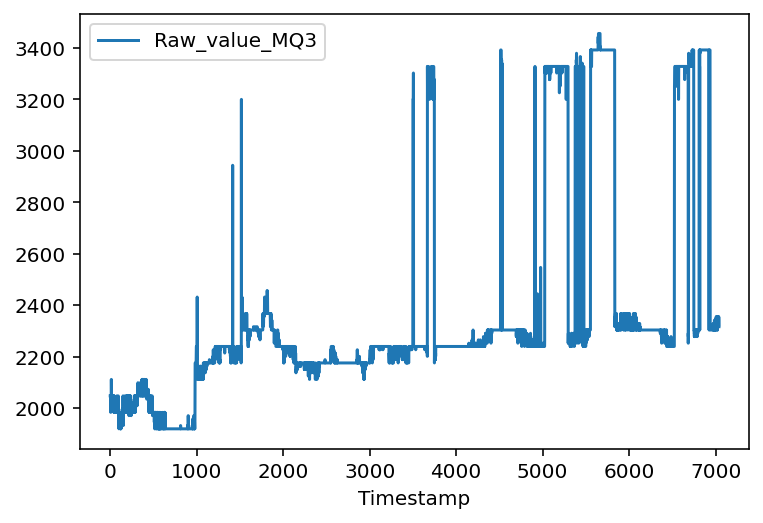

In [44]:
rides[:7000].plot(x='Timestamp', y='Raw_value_MQ3')

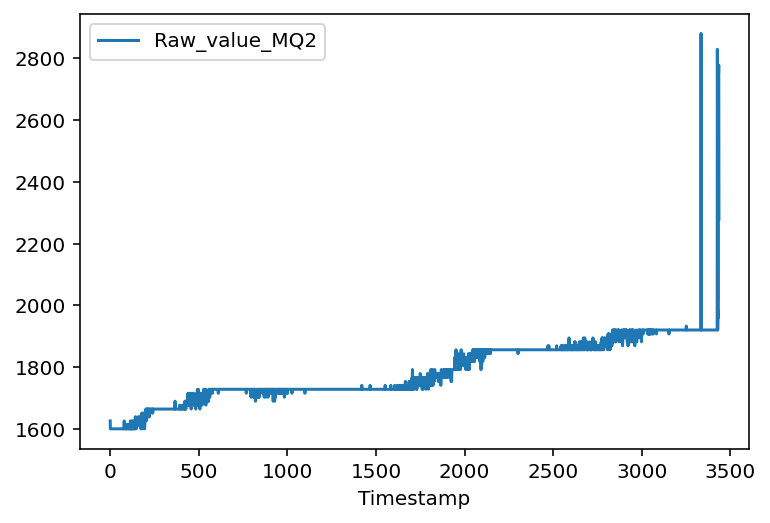

In [57]:
rides_feta[:7000].plot(x='Timestamp', y='Raw_value_MQ2')

##Normalizing the values
We are dividing every log by 65472 wich is the maximum value each sensor can give. For more info read [this](https://github.com/adafruit/Adafruit_CircuitPython_MCP3xxx/blob/main/adafruit_mcp3xxx/analog_in.py#L50-L54).

In [58]:
sensor_names = ['Raw_value_MQ2', 'Raw_value_MQ3', 'Raw_value_MQ4', 'Raw_value_MQ135', 'Raw_value_MQ6', 'Raw_value_MQ7', 'Raw_value_MQ8', 'Raw_value_MQ9']
MAX_VALUE = 65472
for each in sensor_names:
    rides_feta.loc[:, each] = rides_feta[each] / MAX_VALUE

rides_feta[:10]

,Timestamp,Raw_value_MQ2,Raw_value_MQ3,Raw_value_MQ4,Raw_value_MQ135,Raw_value_MQ6,Raw_value_MQ7,Raw_value_MQ8,Raw_value_MQ9,
0,0,0.024829,0.098729,0.01564,0.017595,0.018573,0.028348,0.025415,0.019550,NaN
1,1,0.024438,0.087977,0.01564,0.017595,0.018573,0.028348,0.025415,0.019550,NaN
2,2,0.024438,0.090714,0.01564,0.017400,0.018573,0.028348,0.025611,0.019550,NaN
3,3,0.024438,0.080352,0.01564,0.017595,0.018573,0.028348,0.025806,0.018768,NaN
4,4,0.024438,0.077419,0.01564,0.017595,0.018573,0.028543,0.026197,0.019159,NaN
5,5,0.024438,0.084066,0.01564,0.017400,0.018573,0.028348,0.026393,0.018573,NaN
6,6,0.024438,0.089932,0.01564,0.017400,0.018573,0.028348,0.026002,0.018573,NaN
7,7,0.024438,0.102639,0.01564,0.017400,0.018573,0.028348,0.026393,0.019550,NaN
8,8,0.024438,0.091691,0.01564,0.017400,0.018573,0.028348,0.026197,0.018964,NaN
9,9,0.024438,0.095015,0.01564,0.017595,0.018573,0.028348,0.026393,0.019550,NaN


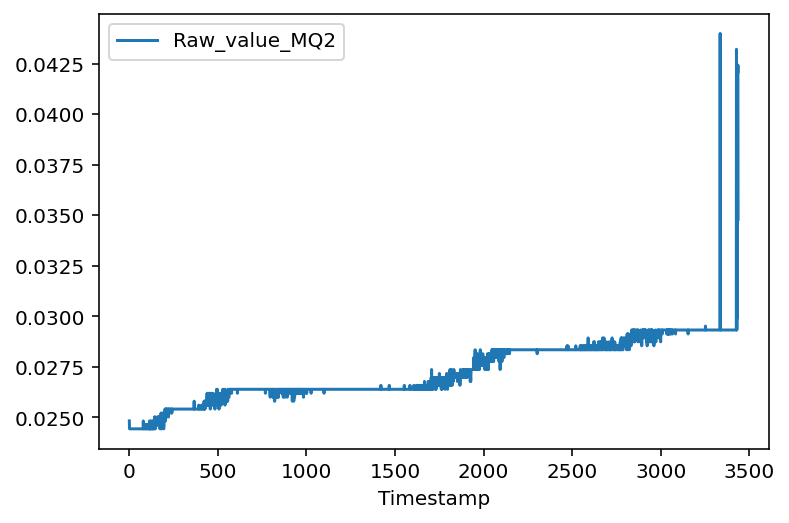

In [59]:
rides_feta[:7000].plot(x='Timestamp', y='Raw_value_MQ2')

### Splitting the data into training, testing, and validation sets

We'll save the data for the first 50 minutes of each day as test set and split the rest as as training and validation sets.

In [ ]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]